# **Regression of Used Cars Prices: Playground Series Season 4 Episode 9**

![Regression of Used Cars Prices](https://cdn.decohere.ai/cus_QoQVFBafnigTTz-stablevideo/outputs/1726094303267/image_0.png?response-content-disposition=attachment%3B%20filename=%22a-visually-striking-title-image-for-my-notebook-focusing-on-the-concept-of--regression-of-used-cars---the-design-features-a-sleek--stylized-representation-of-various-used-cars--arranged-in-a-dyna.png%22)

# Introduction

In this notebook, we explore the problem of predicting the price of used cars using a rich set of features that provide insights into each car's characteristics. The goal is to predict prices accurately, and for this purpose, we employ a variety of machine learning models to evaluate and minimize the Root Mean Squared Error (RMSE). The models used include Linear Regression, Random Forest Regressor, XGBoost Regressor, and an AutoML approach. Through systematic comparison, we aim to identify the model that delivers the most accurate price predictions.

## Dataset Overview

The dataset contains detailed information about the cars, which we use to build our predictive models. Below is a brief explanation of the features:

**id:** Unique identifier for each car.

**brand:** The manufacturer of the car (e.g., MINI, BMW, etc.).

**model:** The specific model of the car.

**model_year:** The year the car model was manufactured.

**mileage:** The total distance the car has traveled, in kilometers or miles.

**fuel_type:** Type of fuel used by the car (e.g., Gasoline, Diesel, etc.).

**engine:** Engine specifications including horsepower and displacement.

**transmission:** The type of transmission (e.g., A/T for automatic, M/T for manual).

**ext_col:** The color of the car's exterior.

**int_col:** The color of the car's interior.

**accident:** Reports of accidents involving the car.

**clean_title:** Whether the car has a clean title (Yes/No).

**price:** The target variable, representing the price of the car.

In the following sections, we delve into the results and analysis of each model’s performance, comparing them based on RMSE and exploring ways to improve accuracy further through feature engineering and model tuning.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


# **Installing required packages**

In [2]:
!pip install h2o
!pip install requests
!pip install tabulate
!pip install future
!pip install "colorama>=0.3.8"
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 952.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer tha

# **Importing all the required libraries**

In [3]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as pltl
import seaborn as sns
from autogluon.tabular import TabularDataset, TabularPredictor
import re

# **Loading the datasets**

In [4]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


# **Checking datasets datatypes**

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


# **Dropping "id" column in datasets**

In [7]:
train_df = train_df.drop('id', axis=1)
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# **Shape of train dataset**

In [8]:
train_df.shape

(188533, 12)

# **Checking if the dataset have null values**

In [9]:
train_df.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [10]:
missing_percentage = train_df.isnull().sum() / len(train_df) * 100
missing_percentage

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

# **Displaying all unique values from fuel_type**

In [11]:
train_df.fuel_type.unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

# **Handling NaNs and replacing a few values with suitable ones**

In [12]:
train_df['fuel_type'] = train_df['fuel_type'].fillna('none')
train_df['fuel_type'] = train_df['fuel_type'].replace({'–': 'none', 'not supported': 'none'})
train_df['fuel_type']

0              Gasoline
1              Gasoline
2         E85 Flex Fuel
3              Gasoline
4              Gasoline
              ...      
188528         Gasoline
188529         Gasoline
188530         Gasoline
188531         Gasoline
188532         Gasoline
Name: fuel_type, Length: 188533, dtype: object

## **Checking unique values in accident column**

In [13]:
train_df.accident.unique()

array(['None reported', 'At least 1 accident or damage reported', nan],
      dtype=object)

## Handling NaN values

In [14]:
train_df['accident'] = train_df['accident'].fillna('None reported')

## Checking unique values in clean_title

In [15]:
train_df.clean_title.unique()

array(['Yes', nan], dtype=object)

## Handling NaN values

In [16]:
train_df['clean_title'] = train_df['clean_title'].fillna('no')

# **Checking unique values and missing values and handling NaN values**

In [17]:
test_df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [18]:
test_df['fuel_type'] = test_df['fuel_type'].fillna('none')
test_df['fuel_type'] = test_df['fuel_type'].replace({'–': 'none', 'not supported': 'none'})

In [19]:
test_df['accident'] = test_df['accident'].fillna('None reported')

In [20]:
test_df['clean_title'] = test_df['clean_title'].fillna('no')

In [21]:
train_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

# **Encoding: Label Encoder**

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = label_encoder.fit_transform(train_df[col])


train_df

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007,213000,2,116,38,312,71,1,0,4200
1,28,930,2002,143250,2,366,38,263,10,0,0,4999
2,9,1575,2002,136731,1,640,38,38,71,1,0,13900
3,16,758,2017,19500,2,863,49,29,14,1,0,45000
4,36,1077,2021,7388,2,259,23,29,10,1,0,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8,604,2017,49000,2,866,49,304,10,1,0,27500
188529,36,206,2018,28600,2,770,31,304,14,0,0,30000
188530,36,223,2021,13650,2,921,23,304,14,1,0,86900
188531,3,1471,2022,13895,2,512,1,82,14,1,1,84900


In [23]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = label_encoder.fit_transform(test_df[col])


test_df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,26,1388,2015,98000,2,326,16,302,10,1,0
1,188534,26,1375,2020,9142,3,787,31,261,14,1,0
2,188535,14,636,2022,28121,2,541,3,302,57,1,1
3,188536,3,182,2016,61258,2,193,39,259,14,1,1
4,188537,3,181,2018,59000,2,365,38,127,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,36,759,2014,83315,2,732,23,29,14,1,0
125686,314219,3,1248,2019,29336,2,511,39,302,14,1,1
125687,314220,3,184,2012,77634,2,673,38,29,14,1,0
125688,314221,3,1244,2012,112000,2,673,38,29,14,1,0


# **Checking number of unique classes**

In [24]:
train_df.nunique()

brand             57
model           1897
model_year        34
milage          6651
fuel_type          6
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        2
price           1569
dtype: int64

# **Description of the entire dataset**

In [25]:
train_df.describe()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,23.161500,867.250566,2015.829998,65705.295174,2.064684,612.825489,29.668827,157.330478,34.996696,0.779524,0.113609,4.387802e+04
std,15.868168,521.804717,5.660967,49798.158076,0.660561,278.163140,13.007453,114.585328,39.856868,0.414569,0.317336,7.881952e+04
min,0.000000,0.000000,1974.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+03
25%,9.000000,431.000000,2013.000000,24115.000000,2.000000,385.000000,20.000000,29.000000,14.000000,1.000000,0.000000,1.700000e+04
50%,21.000000,817.000000,2017.000000,57785.000000,2.000000,627.000000,32.000000,128.000000,14.000000,1.000000,0.000000,3.082500e+04
75%,36.000000,1320.000000,2020.000000,95400.000000,2.000000,853.000000,38.000000,281.000000,56.000000,1.000000,0.000000,4.990000e+04
max,56.000000,1896.000000,2024.000000,405000.000000,5.000000,1116.000000,51.000000,318.000000,155.000000,1.000000,1.000000,2.954083e+06


# **Checking correlation in the dataset**

In [26]:
train_df.corr()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
brand,1.000000,-0.040049,-0.014605,-0.007286,0.194012,-0.065512,0.036984,0.006038,-0.004765,0.005564,0.022153,0.017657
model,-0.040049,1.000000,0.001784,0.041706,0.065739,-0.042079,-0.027031,0.007560,0.076990,-0.017556,0.048268,-0.029865
model_year,-0.014605,0.001784,1.000000,-0.669936,0.114944,0.285300,0.043596,-0.032189,0.024833,0.256367,0.264893,0.231795
milage,-0.007286,0.041706,-0.669936,1.000000,-0.166247,-0.331196,-0.041158,0.027763,-0.030846,-0.321356,-0.242779,-0.283067
fuel_type,0.194012,0.065739,0.114944,-0.166247,1.000000,0.134614,0.004609,-0.002244,0.047620,0.080569,0.038323,0.038037
engine,-0.065512,-0.042079,0.285300,-0.331196,0.134614,1.000000,-0.017717,-0.037814,0.006319,0.163374,-0.059727,0.208285
transmission,0.036984,-0.027031,0.043596,-0.041158,0.004609,-0.017717,1.000000,0.005435,-0.002534,-0.012481,0.067886,0.014560
ext_col,0.006038,0.007560,-0.032189,0.027763,-0.002244,-0.037814,0.005435,1.000000,0.067904,-0.020224,-0.016666,-0.017342
int_col,-0.004765,0.076990,0.024833,-0.030846,0.047620,0.006319,-0.002534,0.067904,1.000000,0.000719,0.084179,0.035174
accident,0.005564,-0.017556,0.256367,-0.321356,0.080569,0.163374,-0.012481,-0.020224,0.000719,1.000000,0.143870,0.125122


# **Model: Linear Regression**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression

X = train_df.drop('price', axis=1)
y = train_df['price']

In [28]:
X

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,31,495,2007,213000,2,116,38,312,71,1,0
1,28,930,2002,143250,2,366,38,263,10,0,0
2,9,1575,2002,136731,1,640,38,38,71,1,0
3,16,758,2017,19500,2,863,49,29,14,1,0
4,36,1077,2021,7388,2,259,23,29,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
188528,8,604,2017,49000,2,866,49,304,10,1,0
188529,36,206,2018,28600,2,770,31,304,14,0,0
188530,36,223,2021,13650,2,921,23,304,14,1,0
188531,3,1471,2022,13895,2,512,1,82,14,1,1


In [29]:
y

0          4200
1          4999
2         13900
3         45000
4         97500
          ...  
188528    27500
188529    30000
188530    86900
188531    84900
188532    28995
Name: price, Length: 188533, dtype: int64

## Training the model

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = lr.predict(X_val)
y_pred
print(len(y_pred))

37707


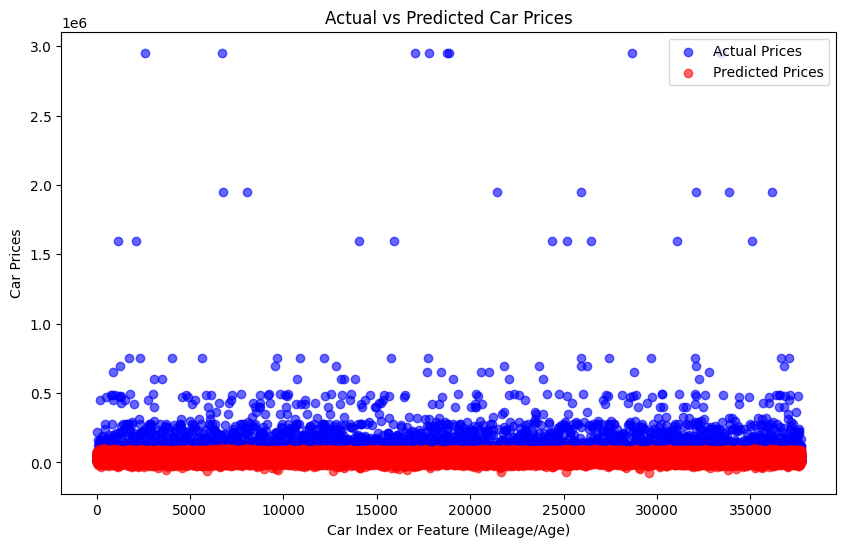

In [33]:
import matplotlib.pyplot as plt

x = range(len(y_pred))

plt.figure(figsize=(10, 6))

# Plot actual prices
plt.scatter(x, y_val, color='blue', label='Actual Prices', alpha=0.6)

# Plot predicted prices
plt.scatter(x, y_pred, color='red', label='Predicted Prices', alpha=0.6)

# Add labels and title
plt.title('Actual vs Predicted Car Prices')
plt.xlabel('Car Index or Feature (Mileage/Age)')
plt.ylabel('Car Prices')
plt.legend()

# Show the plot
plt.show()

In [34]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


70236.12418092758

In [35]:
test_df_without_id = test_df.drop('id', axis=1)
test_df_without_id

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1388,2015,98000,2,326,16,302,10,1,0
1,26,1375,2020,9142,3,787,31,261,14,1,0
2,14,636,2022,28121,2,541,3,302,57,1,1
3,3,182,2016,61258,2,193,39,259,14,1,1
4,3,181,2018,59000,2,365,38,127,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...
125685,36,759,2014,83315,2,732,23,29,14,1,0
125686,3,1248,2019,29336,2,511,39,302,14,1,1
125687,3,184,2012,77634,2,673,38,29,14,1,0
125688,3,1244,2012,112000,2,673,38,29,14,1,0


In [36]:
test_predictions = lr.predict(test_df_without_id)
test_predictions

array([20116.89434554, 65434.79412822, 64548.58189381, ...,
       38508.65893817, 25532.35307079, 44278.81343151])

In [37]:
submission = pd.DataFrame({'id': test_df['id'], 'price': test_predictions})
submission

,id,price
0,188533,20116.894346
1,188534,65434.794128
2,188535,64548.581894
3,188536,35361.990866
4,188537,36689.169210
...,...,...
125685,314218,43256.247174
125686,314219,56436.844690
125687,314220,38508.658938
125688,314221,25532.353071


# **Model: Random Forest Regressor**

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
y_pred_rf = rf.predict(X_val)
y_pred_rf

array([48612.09, 22463.67, 31819.71, ..., 20410.53, 13748.2 , 43076.58])

In [40]:
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
rmse_rf

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


75275.37499312576

In [41]:
y_pred_rf_test = rf.predict(test_df_without_id)
y_pred_rf_test

array([15651.47, 74593.71, 56051.11, ..., 23231.91, 13157.26, 32380.71])

In [42]:
submission_rf = pd.DataFrame({'id': test_df['id'], 'price': y_pred_rf_test})
submission_rf

,id,price
0,188533,15651.47
1,188534,74593.71
2,188535,56051.11
3,188536,26109.86
4,188537,27996.27
...,...,...
125685,314218,24304.63
125686,314219,58092.50
125687,314220,23231.91
125688,314221,13157.26


# **Model: XGBoost Regressor**

In [43]:
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb

# XGBoost parameters (you can further tune these)
params = {'n_estimators': 387, 
          'max_depth': 6, 
          'learning_rate': 0.0221955891150421, 
          'subsample': 0.956049799110561, 
          'colsample_bytree': 0.6020390043948215, 
          'gamma': 5.356447556257337e-08, 
          'min_child_weight': 6, 
          'reg_alpha': 1.282064019440197e-05, 
          'reg_lambda': 5.1415598885152124e-05,
          'loss_function': 'RMSE'
         }

xgbm = XGBRegressor(**params)

In [44]:
xgbm.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:11:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss_function" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6020390043948215, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=5.356447556257337e-08,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0221955891150421,
             loss_function='RMSE', max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=387,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
# Evaluate on validation set
y_pred_xgb = xgbm.predict(X_val)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
rmse_xgb

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


67767.9797409829

In [46]:
# Predict on test set
xgbm_pred = xgbm.predict(test_df_without_id)
xgbm_pred

array([17095.293, 85296.13 , 56444.004, ..., 22845.922, 16237.499,
       36954.062], dtype=float32)

In [47]:
# Prepare submission file
xgbm_submission = pd.DataFrame({'id': test_df['id'], 'price': xgbm_pred})
xgbm_submission

,id,price
0,188533,17095.292969
1,188534,85296.132812
2,188535,56444.003906
3,188536,23742.037109
4,188537,30242.361328
...,...,...
125685,314218,27128.271484
125686,314219,49135.675781
125687,314220,22845.921875
125688,314221,16237.499023


# **Model: AutoML**

In [48]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [49]:
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

14


In [50]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:29261..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu320.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu320.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf49p8e5h
  JVM stdout: /tmp/tmpf49p8e5h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf49p8e5h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:29261
Connecting to H2O server at http://127.0.0.1:29261 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_unknownUser_m4g2u5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [51]:
#Converting pandas dataframe to H2o dataframe

df1 = h2o.H2OFrame(train_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [52]:
df1.types

{'brand': 'int',
 'model': 'int',
 'model_year': 'int',
 'milage': 'int',
 'fuel_type': 'int',
 'engine': 'int',
 'transmission': 'int',
 'ext_col': 'int',
 'int_col': 'int',
 'accident': 'int',
 'clean_title': 'int',
 'price': 'int'}

In [53]:
pct_rows = 0.80  # Setting up the data split between training and validation dataset.
df1_train, df1_val = df1.split_frame([pct_rows])

In [54]:
# Checking the split size
print(df1_train.shape)
print(df1_val.shape)

(151008, 12)
(37525, 12)


In [55]:
df1_train.head()

brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
31,495,2007,213000,2,116,38,312,71,1,0,4200
28,930,2002,143250,2,366,38,263,10,0,0,4999
9,1575,2002,136731,1,640,38,38,71,1,0,13900
16,758,2017,19500,2,863,49,29,14,1,0,45000
3,182,2018,40950,2,364,38,304,155,1,0,29950
3,200,2016,62200,2,673,31,29,14,1,0,28500
9,1554,2016,102604,1,717,38,304,71,1,0,12500
14,670,2020,38352,2,228,3,272,14,1,0,62890
4,976,2015,74850,2,869,49,29,28,1,0,4000
9,398,2011,212500,2,621,38,38,71,0,0,7950


In [56]:
#Setting predictor and target variables
X = df1.columns
print(X)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']


In [57]:
X1 = df1.drop('price', axis=1)
X1

brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
31,495,2007,213000,2,116,38,312,71,1,0
28,930,2002,143250,2,366,38,263,10,0,0
9,1575,2002,136731,1,640,38,38,71,1,0
16,758,2017,19500,2,863,49,29,14,1,0
36,1077,2021,7388,2,259,23,29,10,1,0
3,182,2018,40950,2,364,38,304,155,1,0
3,200,2016,62200,2,673,31,29,14,1,0
9,1554,2016,102604,1,717,38,304,71,1,0
14,670,2020,38352,2,228,3,272,14,1,0
4,976,2015,74850,2,869,49,29,28,1,0


In [58]:
y1 = df1['price']
y1

price
4200
4999
13900
45000
97500
29950
28500
12500
62890
4000


In [59]:
y = "price"
X.remove(y)  # Removing the result from our predictors data
print(X)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [60]:
# Setting of AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=42)

In [61]:
# Training the dataset on different models
aml.train(x=X, y=y, training_frame=df1_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),10/12
# GBM base models (used / total),5/5
# XGBoost base models (used / total),3/3
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [62]:
# Leaderboard displaying the effectiveness of several models on the dataset.
aml.leaderboard

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20240915_71219,72292.3,5.22618e+09,19329.8,0.537809,5.22618e+09
StackedEnsemble_AllModels_1_AutoML_1_20240915_71219,72295.4,5.22662e+09,19324.1,0.538967,5.22662e+09
StackedEnsemble_BestOfFamily_3_AutoML_1_20240915_71219,72327,5.23119e+09,19395.1,nan,5.23119e+09
StackedEnsemble_BestOfFamily_2_AutoML_1_20240915_71219,72343.2,5.23354e+09,19417.9,nan,5.23354e+09
StackedEnsemble_BestOfFamily_1_AutoML_1_20240915_71219,72356.2,5.23542e+09,19438.4,nan,5.23542e+09
GBM_1_AutoML_1_20240915_71219,72357.1,5.23555e+09,19456.6,nan,5.23555e+09
GBM_2_AutoML_1_20240915_71219,72562.9,5.26537e+09,19611.4,nan,5.26537e+09
GBM_3_AutoML_1_20240915_71219,72611.6,5.27245e+09,19609.6,nan,5.27245e+09
GBM_4_AutoML_1_20240915_71219,72842.5,5.30603e+09,19922.2,nan,5.30603e+09
DeepLearning_1_AutoML_1_20240915_71219,73815.1,5.44867e+09,19907.4,nan,5.44867e+09


In [63]:
model_id = 0
best_model = h2o.get_model(aml.leaderboard[model_id, 'model_id'])
best_model.algo

'stackedensemble'

In [64]:
rmse_aml = best_model.rmse()
rmse_aml

77907.83806019223

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_1_20240915_71219,51793.8,2.6826e+09,13682.7,0.412716,2.6826e+09,1126,0.00098,DRF
XGBoost_1_AutoML_1_20240915_71219,58397.1,3.41022e+09,18820.7,nan,3.41022e+09,7090,0.005647,XGBoost
XGBoost_2_AutoML_1_20240915_71219,63862.2,4.07838e+09,19033.8,nan,4.07838e+09,2806,0.001467,XGBoost
GBM_4_AutoML_1_20240915_71219,68007.3,4.62499e+09,18903.1,0.558567,4.62499e+09,2330,0.004485,GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20240915_71219,68892.9,4.74623e+09,18423.6,0.515135,4.74623e+09,895,0.011362,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240915_71219,68909.6,4.74853e+09,18475.3,0.512285,4.74853e+09,1151,0.023967,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240915_71219,68910.8,4.7487e+09,18549.6,0.512615,4.7487e+09,1314,0.061967,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20240915_71219,68991,4.75976e+09,18684.1,0.518194,4.75976e+09,968,0.047281,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240915_71219,69029.6,4.76508e+09,18381.9,0.514459,4.76508e+09,1352,0.013986,StackedEnsemble
GBM_1_AutoML_1_20240915_71219,69597.7,4.84384e+09,18517.4,0.516899,4.84384e+09,6857,0.011731,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

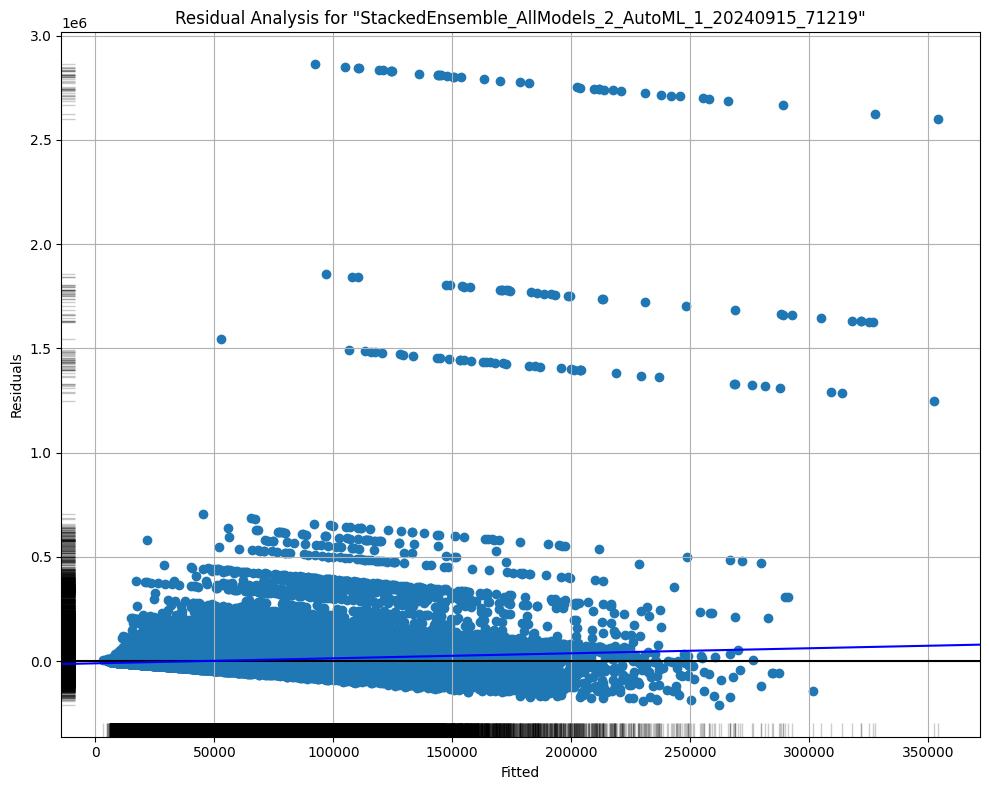

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

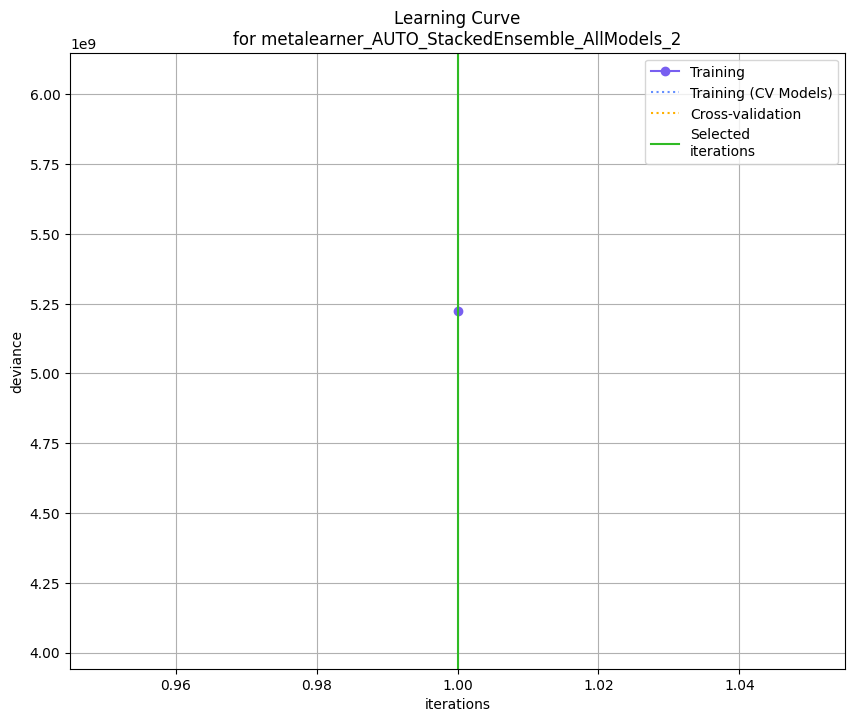

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

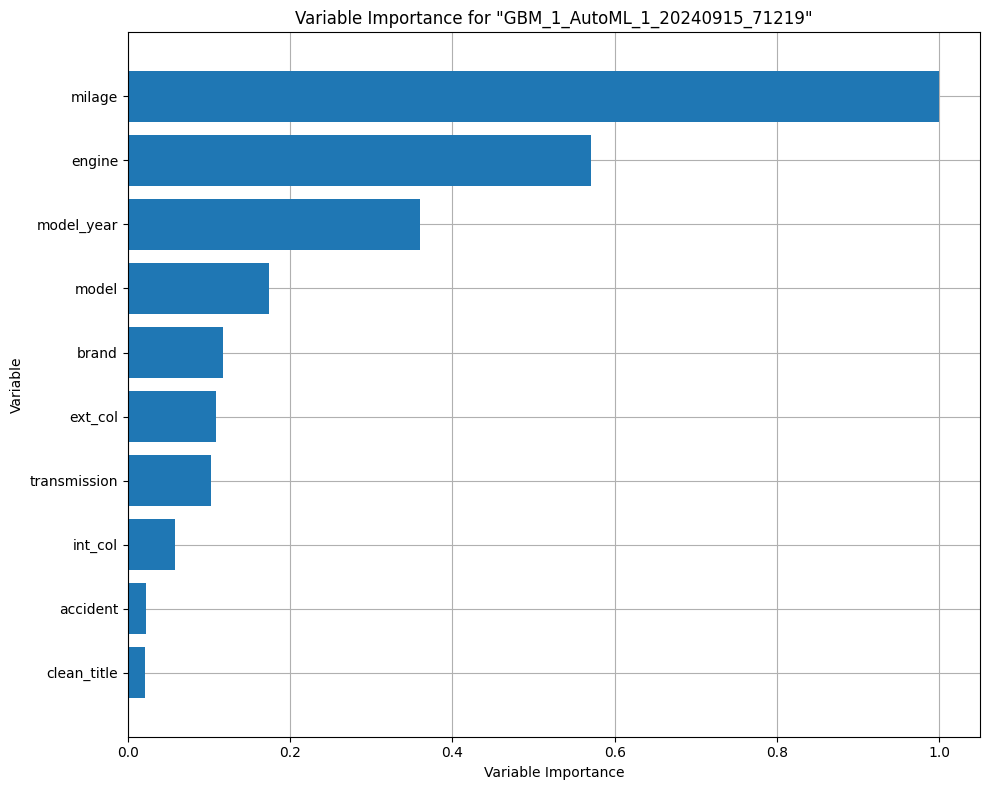

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

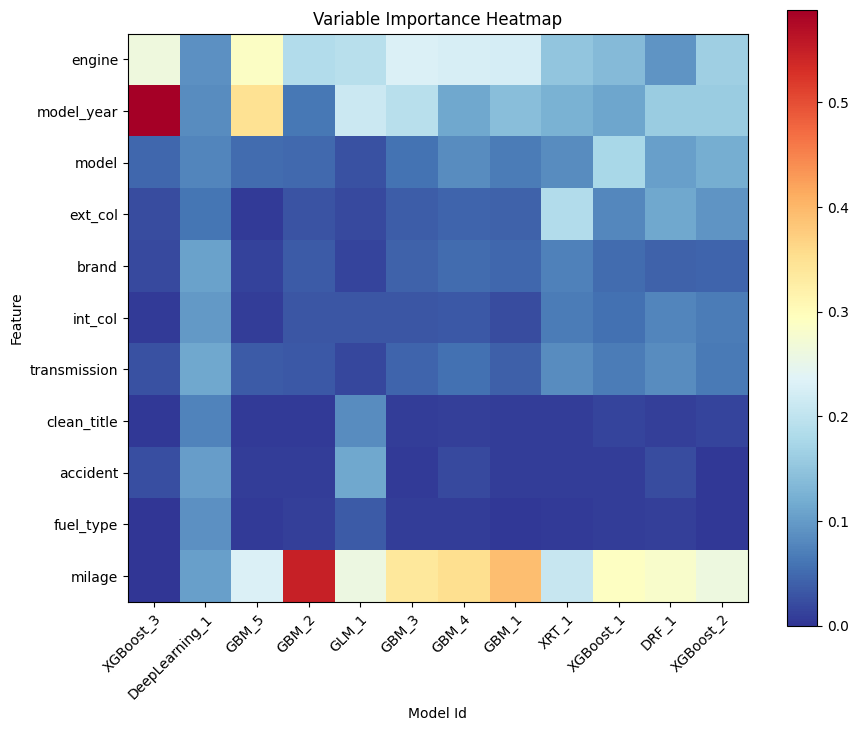

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

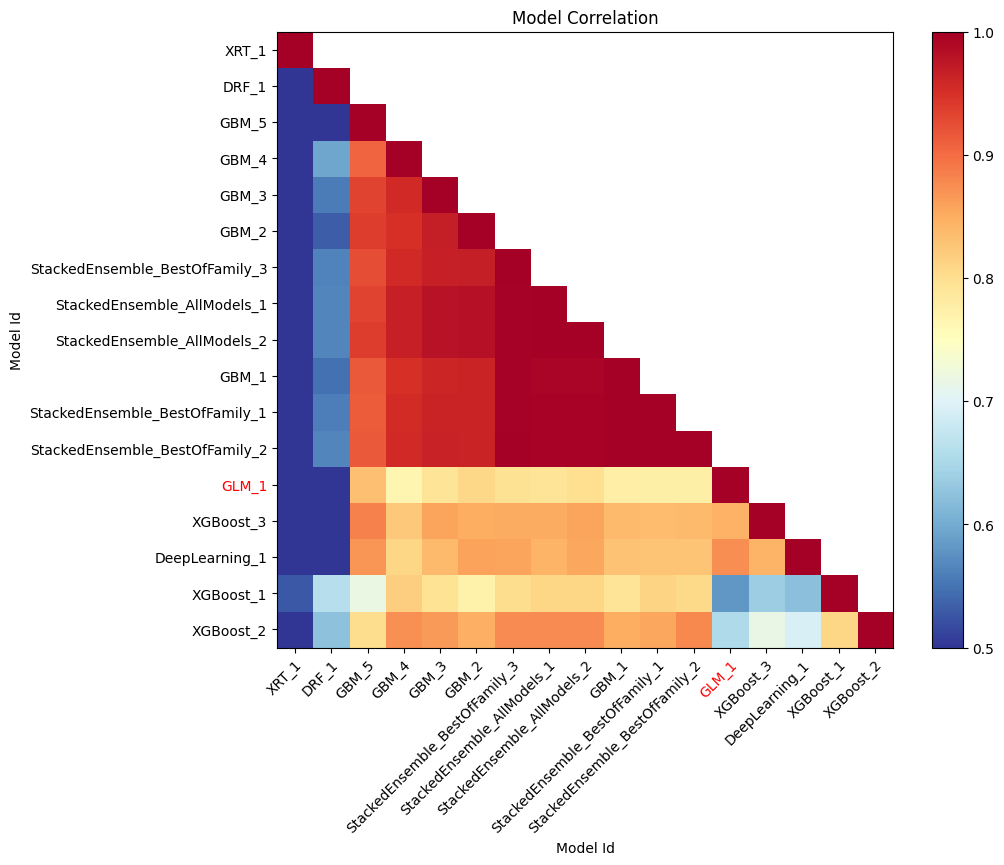

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

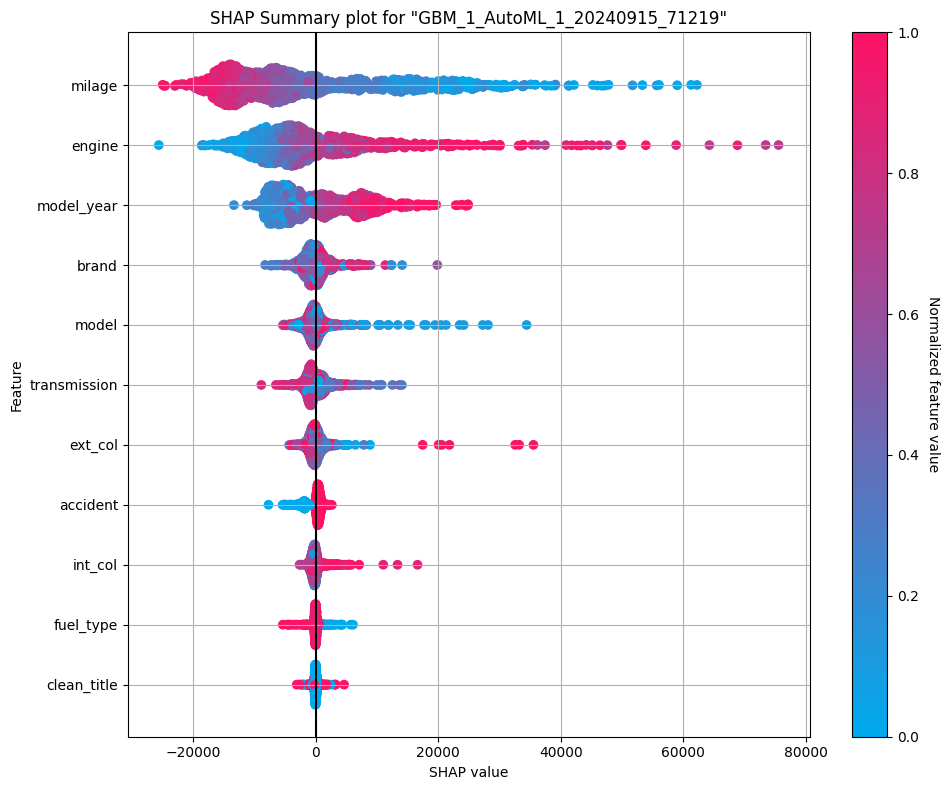

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_1_20240915_71219,51793.8,2.6826e+09,13682.7,0.412716,2.6826e+09,1126,0.00098,DRF
XGBoost_1_AutoML_1_20240915_71219,58397.1,3.41022e+09,18820.7,nan,3.41022e+09,7090,0.005647,XGBoost
XGBoost_2_AutoML_1_20240915_71219,63862.2,4.07838e+09,19033.8,nan,4.07838e+09,2806,0.001467,XGBoost
GBM_4_AutoML_1_20240915_71219,68007.3,4.62499e+09,18903.1,0.558567,4.62499e+09,2330,0.004485,GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20240915_71219,68892.9,4.74623e+09,18423.6,0.515135,4.74623e+09,895,0.011362,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240915_71219,68909.6,4.74853e+09,18475.3,0.512285,4.74853e+09,1151,0.023967,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240915_71219,68910.8,4.7487e+09,18549.6,0.512615,4.7487e+09,1314,0.061967,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20240915_71219,68991,4.75976e+09,18684.1,0.518194,4.75976e+09,968,0.047281,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240915_71219,69029.6,4.76508e+09,18381.9,0.514459,4.76508e+09,1352,0.013986,StackedEnsemble
GBM_1_AutoML_1_20240915_71219,69597.7,4.84384e+09,18517.4,0.516899,4.84384e+09,6857,0.011731,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

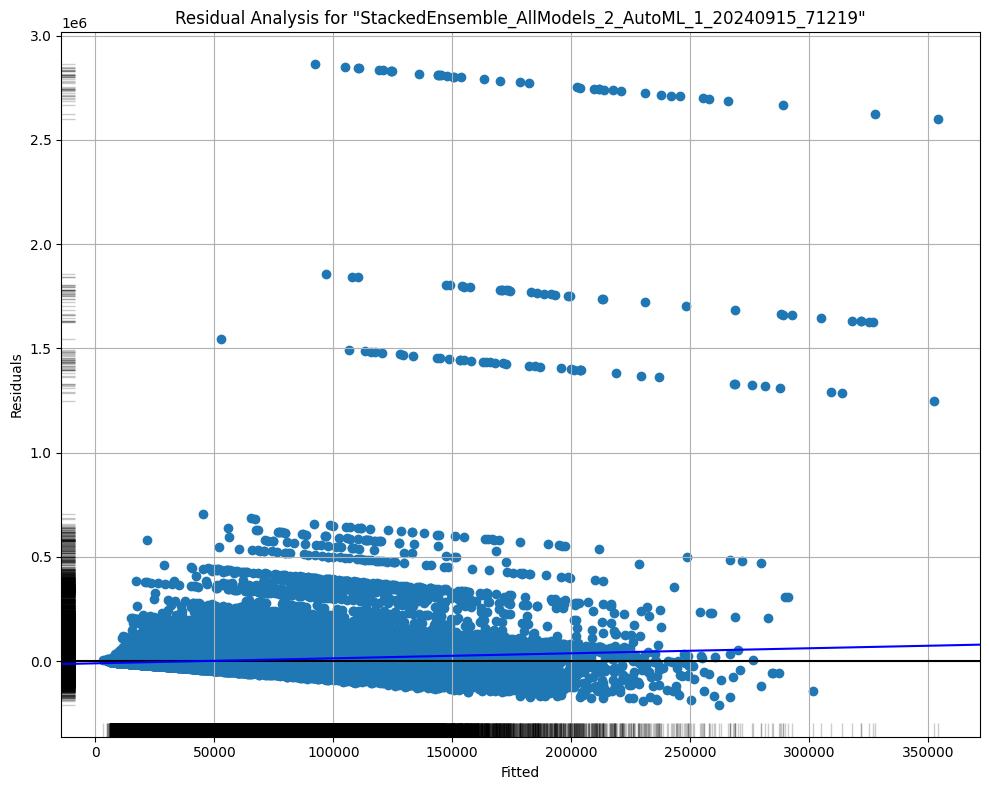

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

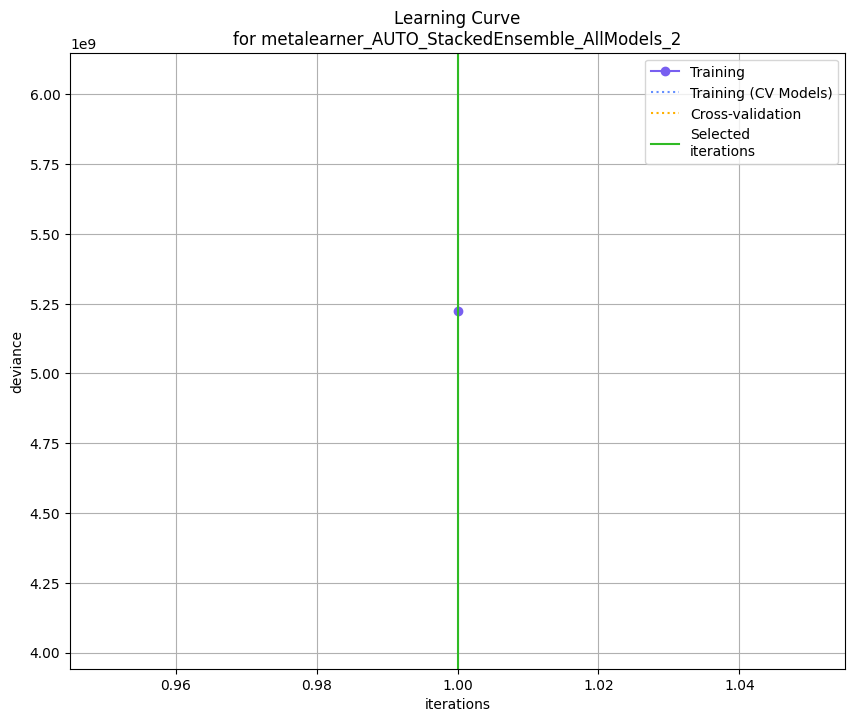

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

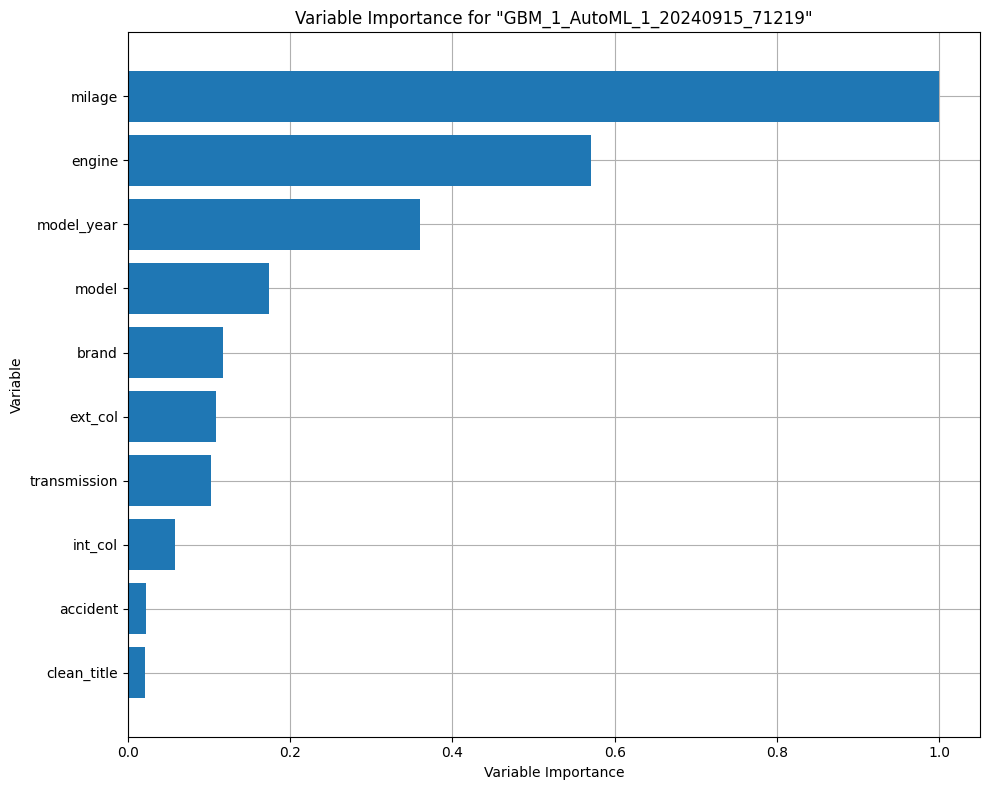

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

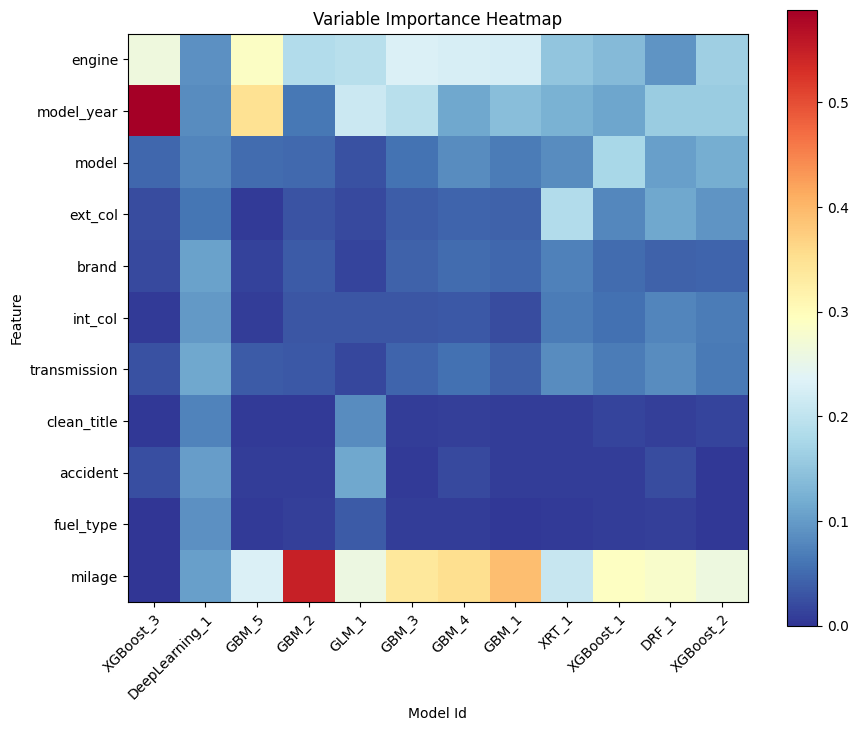

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

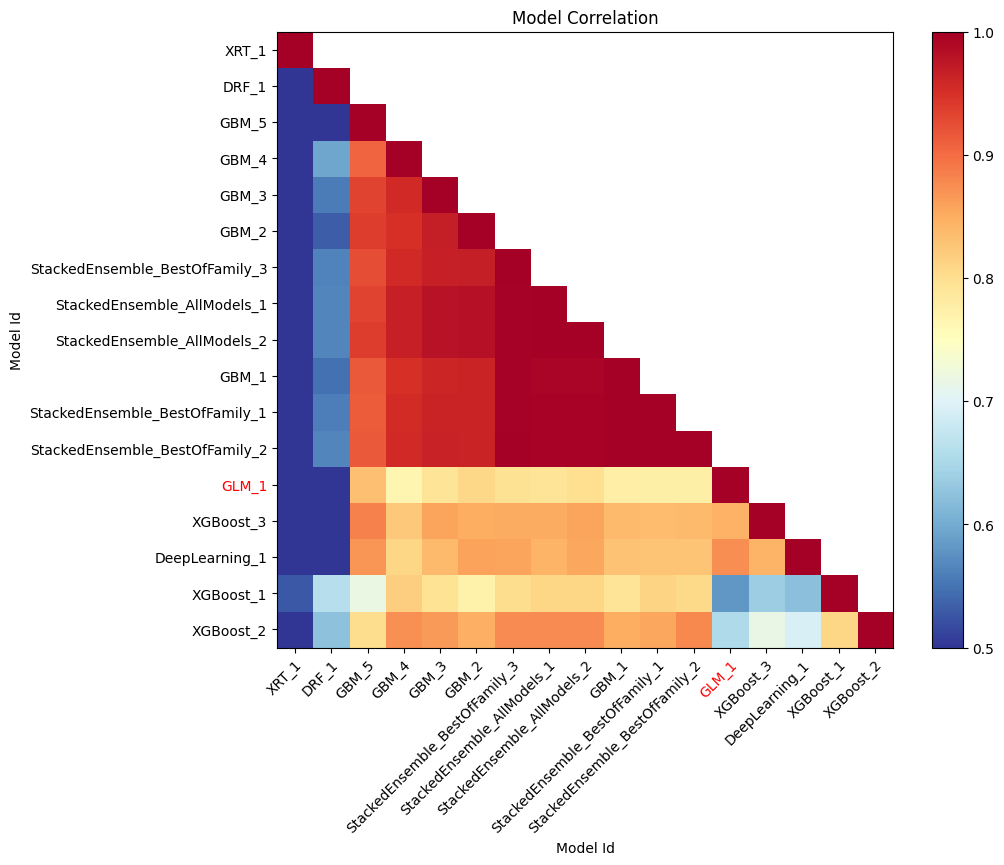

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

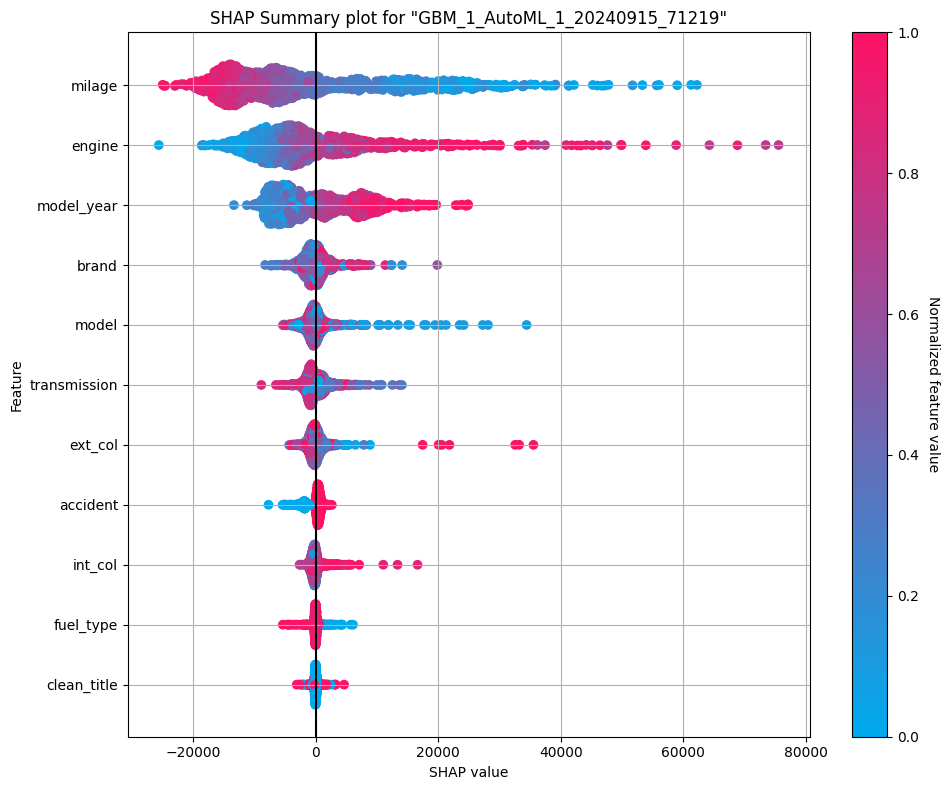

In [65]:
explain_model = aml.explain(frame = df1_train, figsize = (10,8), exclude_explanations=['pdp', 'ice'])
explain_model

In [66]:
df2 = h2o.H2OFrame(test_df_without_id)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [67]:
aml_test_predictions = best_model.predict(df2)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [68]:
aml_test_predictions = aml_test_predictions.as_data_frame()
aml_test_predictions

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict
0,17325.789579
1,81856.779744
2,55381.493309
3,26097.767865
4,30136.221029
...,...
125685,25662.997129
125686,49338.285132
125687,23026.038621
125688,16465.376896


In [69]:
aml_submission = pd.DataFrame({'id': test_df['id'], 'price': aml_test_predictions['predict']})
aml_submission

,id,price
0,188533,17325.789579
1,188534,81856.779744
2,188535,55381.493309
3,188536,26097.767865
4,188537,30136.221029
...,...,...
125685,314218,25662.997129
125686,314219,49338.285132
125687,314220,23026.038621
125688,314221,16465.376896


# **Model: AutoGluon**

In [70]:
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

In [71]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [72]:
train['fuel_type'] = train['fuel_type'].fillna('none')
train['fuel_type'] = train['fuel_type'].replace({'–': 'none', 'not supported': 'none'})

In [73]:
train['accident'] = train['accident'].fillna('None reported')

In [74]:
train['clean_title'] = train['clean_title'].fillna('no')

In [75]:
test['fuel_type'] = test['fuel_type'].fillna('none')
test['fuel_type'] = test['fuel_type'].replace({'–': 'none', 'not supported': 'none'})

In [76]:
test['accident'] = test['accident'].fillna('None reported')

In [77]:
test['clean_title'] = test['clean_title'].fillna('no')

In [78]:
print(train.isnull().sum())
print(test.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     188533 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      188533 non-null  object
 10  clean_title   188533 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [80]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [81]:
%%time 

agl = TabularPredictor(label='price').fit(train, presets='best_quality',time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240915_071742"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       18.81 GB / 31.36 GB (60.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets o

CPU times: user 35min 20s, sys: 11.6 s, total: 35min 32s
Wall time: 1h 31s


In [82]:
leaderboard = agl.leaderboard()
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-72622.404789,root_mean_squared_error,175.820840,1922.976538,0.003921,0.356713,3,True,11
1,WeightedEnsemble_L2,-72686.157176,root_mean_squared_error,95.528933,1206.442943,0.004592,0.544405,2,True,7
2,LightGBMXT_BAG_L2,-72708.287813,root_mean_squared_error,167.544516,1269.035754,2.928599,62.559690,2,True,8
3,LightGBMXT_BAG_L1,-72895.388239,root_mean_squared_error,5.591440,66.219610,5.591440,66.219610,1,True,3
4,CatBoost_BAG_L1,-72926.285777,root_mean_squared_error,1.226315,156.247556,1.226315,156.247556,1,True,6
5,LightGBM_BAG_L2,-73094.754998,root_mean_squared_error,167.040880,1262.628828,2.424963,56.152765,2,True,9
6,LightGBM_BAG_L1,-73198.389391,root_mean_squared_error,4.053802,57.703300,4.053802,57.703300,1,True,4
7,RandomForestMSE_BAG_L2,-76002.742230,root_mean_squared_error,170.463357,1803.907370,5.847440,597.431306,2,True,10
8,RandomForestMSE_BAG_L1,-78309.103698,root_mean_squared_error,13.627832,924.939383,13.627832,924.939383,1,True,5
9,KNeighborsUnif_BAG_L1,-78815.444292,root_mean_squared_error,71.024951,0.788689,71.024951,0.788689,1,True,1


In [83]:
best_model_agl = agl.get_model_best()
print(best_model_agl)

WeightedEnsemble_L3


/tmp/ipykernel_17/2186607933.py:1: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model_agl = agl.get_model_best()


In [84]:
rmse_agl = agl.leaderboard().loc[agl.leaderboard()['model'] == best_model_agl, 'score_val'].values[0]
rmse_agl

-72622.40478932054

# **Submission**

In [85]:
agl_predictions = agl.predict(test)
agl_predictions

0         19369.681641
1         89839.773438
2         57725.984375
3         30921.617188
4         32174.273438
              ...     
125685    28332.167969
125686    52387.269531
125687    21425.617188
125688    16473.234375
125689    34585.312500
Name: price, Length: 125690, dtype: float32

In [86]:
agl_submission = pd.DataFrame({'id': test_df['id'], 'price': agl_predictions})
agl_submission

,id,price
0,188533,19369.681641
1,188534,89839.773438
2,188535,57725.984375
3,188536,30921.617188
4,188537,32174.273438
...,...,...
125685,314218,28332.167969
125686,314219,52387.269531
125687,314220,21425.617188
125688,314221,16473.234375


In [87]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'AutoML', 'AutoGluon'],
    'RMSE': [rmse, rmse_rf, rmse_xgb, rmse_aml, rmse_agl], 
})
results_sorted = results.sort_values('RMSE', ascending=True)
results_sorted

,Model,RMSE
4,AutoGluon,-72622.404789
2,XGBoost,67767.979741
0,Linear Regression,70236.124181
1,Random Forest,75275.374993
3,AutoML,77907.838060


In [88]:
agl_submission.to_csv('submission.csv', index=False)

# **Summary**

In this notebook, I evaluated multiple models to predict used car prices, including **Linear Regression**, **Random Forest Regressor**, **XGBoost Regressor**, **AutoML** and **AutoGluon**. Each model was tested to minimize **Root Mean Squared Error (RMSE)**

### Conclusion:
I plan to refine models for further improvements. Please **upvote** if you found this helpful, as it motivates me to create more quality notebooks!